In [68]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler

# Загрузка данных

In [69]:
data = pd.read_csv('datasets\\understat_per_game.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24580 entries, 0 to 24579
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   league        24580 non-null  object 
 1   year          24580 non-null  int64  
 2   h_a           24580 non-null  object 
 3   xG            24580 non-null  float64
 4   xGA           24580 non-null  float64
 5   npxG          24580 non-null  float64
 6   npxGA         24580 non-null  float64
 7   deep          24580 non-null  int64  
 8   deep_allowed  24580 non-null  int64  
 9   scored        24580 non-null  int64  
 10  missed        24580 non-null  int64  
 11  xpts          24580 non-null  float64
 12  result        24580 non-null  object 
 13  date          24580 non-null  object 
 14  wins          24580 non-null  int64  
 15  draws         24580 non-null  int64  
 16  loses         24580 non-null  int64  
 17  pts           24580 non-null  int64  
 18  npxGD         24580 non-nu

Выбранный датасет содержит результаты футбольных матчей в 6-ти лигах за сезоны 2014/2015 - 2019/2020.

In [70]:
data['league'].value_counts()

league
EPL           4560
La_liga       4560
Serie_A       4550
Ligue_1       4358
Bundesliga    3672
RFPL          2880
Name: count, dtype: int64

В датасете все матчи представлены дважды: по разу со стороны каждой команды.
Сводка по лигам:
- Английская и испанская лиги (EPL, La_liga) представлены полностью: 
    4560 записей = 10 матчей в туре (так как 20 команд в турнире) * 38 туров (какждый играет с каждым дважды) * 6 сезонов * 2 записей/матч
- Итальянская лига (Serie_A) - отсутсвует последний тур последнего сезона, что не влияет на дальнейшую работу.
- Французская лига (Ligue_1) - сезон 2019/2020 не был доигран из-за пандемии, поэтому матчей меньше.
- Немецкая лига (Bundesliga) представлена полностью (состав турнира = 18 команд)
- Российская лига (RFPL) представлена полностью (состав турнира = 16 команд)

# Постановка задачи

In [71]:
data['result'].value_counts(normalize=True)

result
w    0.373841
l    0.373841
d    0.252319
Name: proportion, dtype: float64

Задача: предсказывать результат матчей (классификация: победа, ничья, поражение) в чемпионате на основании информации о последних пяти матчах команд и количества набранных очков в сезоне на момент начала встречи.

Для оценки точности будем использовать точность (Accuracy) и многоклассовую f1-меру:
- Так как у нас достаточно сбалансированные классы, то показатель точности не будет сильно искажен этим фактом. 
- Если бы учитывалось название команды, то показатель точности стал бы намного менее информативным, так как есть сильные команды с высоким процентом побед, и слабые - с очень низким. Так как классы сбалансированы, то разница между макро и микро f1-мерой незначительна.
    
Выделим следующие показатели для простой модели:
- доля набранных очков за сезон - характеристика силы команды в сезоне
- доля набранных очков за предыдущие 5 матчей (в текущем сезоне) - характеристика текущей формы команды в сезоне
- количество забитых и пропущенных мячей в последних 5-ти матчах (в текущем сезоне) - характеристика текущей формы команды в сезоне
- играет ли команда дома - полагется, что игра дома увеличивает вероятность победы.

Набор признаков сформирован из предположения, что одна и та же команда в разные сезоны может сильно отличаться, именно поэтому признаки учитывают только предыдущую информацию в текущем сезоне.

# Формирование новых признаков

## Разделение матчей по сезонам

Требуется разметить все матчи по номеру сезона. Граница между сезонами - июнь. Посмторим распределение матчей по месяцам за весь представленный промежуток, убедимся в границе.

In [72]:
data['month'] = data['date'].str[:7]
count_by_months = data[['league','month','date']].groupby(['league','month']).count().reset_index()
count_by_months[count_by_months['month'].str[-2:].astype(int).between(6,8)]

,league,month,date
0,Bundesliga,2014-08,36
10,Bundesliga,2015-08,54
20,Bundesliga,2016-08,18
30,Bundesliga,2017-08,36
40,Bundesliga,2018-08,20
50,Bundesliga,2019-08,50
59,Bundesliga,2020-06,94
60,EPL,2014-08,60
70,EPL,2015-08,80
80,EPL,2016-08,60


Как видно из представленной таблицы за исключением 2020-го года (перенос матчей из-за пандемии), во всех лигах не проводятся матчи в июне. Поэтому будем считать Июнь - границей между сезонами.
Добавим новый признак - номер сезона, так что 2014/2015 - 1, ... 2019/2020 - 6. А для последнего 6-го сезона отдельно пропишем исключение, подразумевающее проведение матчей после июня. Так как это последний сезон, то нет необходимости знать точную дату его окончания, достаточно просто ограничить номер сезона числом 6.

In [73]:
def get_season_number(date_match):
    year = int(date_match[:4])
    month = int(date_match[5:7])
    season_number = year - 2014
    if (month > 6) and (year < 2020):
        season_number += 1
    return season_number

data['season_number'] = data['date'].astype('str').apply(get_season_number)

data[['date','season_number']].sample(n=10, random_state=11)

,date,season_number
873,2016-03-02 23:00:00,2
10106,2016-11-27 23:45:00,3
7918,2020-03-07 15:00:00,6
19357,2019-03-01 13:30:00,5
17587,2015-03-09 12:30:00,1
17758,2015-09-18 20:00:00,2
1003,2016-01-23 18:30:00,2
3310,2019-12-02 19:30:00,6
17913,2015-11-01 20:00:00,2
19499,2018-10-05 16:30:00,5


## Добавление признаков

Разметим команду противника в каждом матче и удалим неиспользуемые признаки.

In [74]:
data_merged = data.merge(data[["team", "xG", "xGA", "date",'scored', 'missed', 'ppda_coef']], 
                         left_on=['date','xG', 'xGA', 'scored', 'missed', 'oppda_coef'], 
                         right_on=['date','xGA', 'xG', 'missed', 'scored', 'ppda_coef'],
                         suffixes=('','_opp'), validate='one_to_one')

data_merged_filtered = data_merged[['season_number', 'h_a', 'team', 'team_opp', 'scored', 'missed',
                                    'result', 'pts','league','date']].copy()
# data_merged.drop(['year', 'wins', 'draws', 'loses', 'ppda_att','ppda_def','oppda_att',
#                                          'oppda_def', 'xG_a', 'xGA_a', 'missed_a', 'scored_a', 'ppda_coef_a', 
#                                          'xGA_diff','month', 'xpts', ''], axis=1)
data_merged_filtered.head()

,season_number,h_a,team,team_opp,scored,missed,result,pts,league,date
0,1,h,Bayern Munich,Wolfsburg,2,1,w,3,Bundesliga,2014-08-22 19:30:00
1,1,a,Bayern Munich,Schalke 04,1,1,d,1,Bundesliga,2014-08-30 17:30:00
2,1,h,Bayern Munich,VfB Stuttgart,2,0,w,3,Bundesliga,2014-09-13 14:30:00
3,1,a,Bayern Munich,Hamburger SV,0,0,d,1,Bundesliga,2014-09-20 14:30:00
4,1,h,Bayern Munich,Paderborn,4,0,w,3,Bundesliga,2014-09-23 19:00:00


Посчитаем сумму очков к моменту начала матча, к концу мачта, тур/номер матча для команды (в соответствии с датой, не реальным расписанием игр). Посчитаем количество очков, забитых и пропущенных голов за последние 5 матчей в пределах текущего сезона для каждого матча.

Добавим все характеристики в качестве новых признаков к датасету.

In [75]:
grouped = data_merged_filtered.groupby(by=['season_number','team'], sort=['date'])
data_grouped = data_merged_filtered.copy()

data_grouped['points_after'] = grouped['pts'].cumsum()
data_grouped['points_before'] = data_grouped['points_after'] - data_grouped['pts']

data_grouped['round'] = grouped.cumcount() + 1

data_grouped['points_last_matches'] = grouped['pts'].rolling(6).sum().reset_index(level=[0,1])['pts']
data_grouped['points_last_matches'] = data_grouped['points_last_matches'] - data_grouped['pts']

data_grouped['scored_last_matches'] = grouped['scored'].rolling(6).sum().reset_index(level=[0,1])['scored']
data_grouped['scored_last_matches'] = data_grouped['scored_last_matches'] - data_grouped['scored']

data_grouped['missed_last_matches'] = grouped['missed'].rolling(6).sum().reset_index(level=[0,1])['missed']
data_grouped['missed_last_matches'] = data_grouped['missed_last_matches'] - data_grouped['missed']

data_grouped['points_last_match'] = grouped['pts'].shift(1)

data_grouped.drop(['league', 'date'], axis=1).head(10)

,season_number,h_a,team,team_opp,scored,missed,result,pts,points_after,points_before,round,points_last_matches,scored_last_matches,missed_last_matches,points_last_match
0,1,h,Bayern Munich,Wolfsburg,2,1,w,3,3,0,1,NaN,NaN,NaN,NaN
1,1,a,Bayern Munich,Schalke 04,1,1,d,1,4,3,2,NaN,NaN,NaN,3.0
2,1,h,Bayern Munich,VfB Stuttgart,2,0,w,3,7,4,3,NaN,NaN,NaN,1.0
3,1,a,Bayern Munich,Hamburger SV,0,0,d,1,8,7,4,NaN,NaN,NaN,3.0
4,1,h,Bayern Munich,Paderborn,4,0,w,3,11,8,5,NaN,NaN,NaN,1.0
5,1,a,Bayern Munich,FC Cologne,2,0,w,3,14,11,6,11.0,9.0,2.0,3.0
6,1,h,Bayern Munich,Hannover 96,4,0,w,3,17,14,7,11.0,9.0,1.0,3.0
7,1,h,Bayern Munich,Werder Bremen,6,0,w,3,20,17,8,13.0,12.0,0.0,3.0
8,1,a,Bayern Munich,Borussia M.Gladbach,0,0,d,1,21,20,9,13.0,16.0,0.0,3.0
9,1,h,Bayern Munich,Borussia Dortmund,2,1,w,3,24,21,10,13.0,16.0,0.0,1.0


Добавим для каждого матча классическую запись результата в качестве отдельного признака по форме:

"команда хозяин" "забитые мячи хозяев":"забитые мячи гостей" "команда гость", пример: Bayern Munich 2:1 Wolfsburg

In [76]:
def create_match_label(h_a, team, team_a, scored, missed):
    if h_a == 'h':
        match_label = "{} {:d}:{:d} {}".format(team, scored, missed, team_a)
    else:
        match_label = "{} {:d}:{:d} {}".format(team_a, missed, scored, team)
    return match_label

data_grouped['match_label'] = data_grouped.apply(lambda x: create_match_label(x['h_a'], x['team'],  x['team_opp'],  x['scored'],  x['missed']), axis=1)
data_grouped[['h_a','points_before', 'pts', 'points_after', 'match_label', 'round']]

,h_a,points_before,pts,points_after,match_label,round
0,h,0,3,3,Bayern Munich 2:1 Wolfsburg,1
1,a,3,1,4,Schalke 04 1:1 Bayern Munich,2
2,h,4,3,7,Bayern Munich 2:0 VfB Stuttgart,3
3,a,7,1,8,Hamburger SV 0:0 Bayern Munich,4
4,h,8,3,11,Bayern Munich 4:0 Paderborn,5
...,...,...,...,...,...,...
24575,h,29,0,29,Lecce 1:3 Fiorentina,33
24576,a,29,0,29,Genoa 2:1 Lecce,34
24577,h,29,3,32,Lecce 3:1 Brescia,35
24578,a,32,0,32,Bologna 3:2 Lecce,36


# Подготовка признаков

Разметим показатели противостоящей команды и оставим только указанные показатели, требуемые для обучения модели. Удалим строки NaN, то есть первые матчи сезона, так как для них невозможно расчитать показатели последних 5-ти матчей.

In [77]:
data_to_train_full = data_grouped.merge(data_grouped[['match_label', 'date', 'team', 'points_last_matches', 
                                                 'scored_last_matches', 'missed_last_matches', 'points_before', 'round']], 
                                   left_on=['match_label','date', 'team_opp'], 
                                   right_on=['match_label','date', 'team'],
                                   suffixes=('','_opp'), validate='one_to_one'
                                  )
data_to_train_full['ishome'] = data_to_train_full['h_a'] == 'h'
data_to_train_dropna = data_to_train_full[['points_before', 'points_last_matches', 'scored_last_matches', 'missed_last_matches',
                                    'points_before_opp', 'points_last_matches_opp', 'scored_last_matches_opp', 'missed_last_matches_opp', 
                                    'ishome', 'result', 'round', 'round_opp']].copy().dropna()

## Выделение долей и средних показателей

Переведем суммарное количество очков в долю от максимального, а сумму голов - в среднее за матчи.

In [78]:
data_to_train['points_last_matches'] = data_to_train_dropna['points_last_matches'] / 15
data_to_train['points_last_matches_opp'] = data_to_train_dropna['points_last_matches_opp'] / 15

data_to_train['scored_last_matches'] = data_to_train_dropna['scored_last_matches'] / 5
data_to_train['scored_last_matches_opp'] = data_to_train_dropna['scored_last_matches_opp'] / 5

data_to_train['missed_last_matches'] = data_to_train_dropna['missed_last_matches'] / 5
data_to_train['missed_last_matches_opp'] = data_to_train_dropna['missed_last_matches_opp'] / 5

data_to_train['points_before'] = data_to_train_dropna['points_before'] / ((data_to_train_dropna['round'] - 1) * 3)
data_to_train['points_before_opp'] = data_to_train_dropna['points_before_opp'] / ((data_to_train_dropna['round_opp'] - 1) * 3)
data_to_train[['ishome', 'result']] = data_to_train_dropna[['ishome', 'result']]
data_to_train.describe()

,points_before,points_last_matches,scored_last_matches,missed_last_matches,points_before_opp,points_last_matches_opp,scored_last_matches_opp,missed_last_matches_opp
count,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000
mean,0.457490,0.457549,1.332820,1.332139,0.457490,0.457549,1.332820,1.332139
std,0.170258,0.226256,0.667785,0.599115,0.170258,0.226256,0.667785,0.599115
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.266667,0.800000,1.000000,0.333333,0.266667,0.800000,1.000000
50%,0.435897,0.466667,1.200000,1.200000,0.435897,0.466667,1.200000,1.200000
75%,0.561404,0.600000,1.600000,1.800000,0.561404,0.600000,1.600000,1.800000
max,1.000000,1.000000,5.000000,4.200000,1.000000,1.000000,5.000000,4.200000


Исходя из представленных характеристик видно, что показатели, связанные с очками (доля набранных очков за сезон, доля набранных очков за предыдущие 5 матчей), нормализованы верно (минимальное значение = 0, максимальное значение = 1).

## Анализ выбросов

Посмторим распределение показателей, связанных с голами в последних матчей. Так как показатели для первой и второй команда (\_opp) одинаковы с точностью до перестановок, рассмотрим только показатели для первой команды.

<Axes: xlabel='missed_last_matches'>

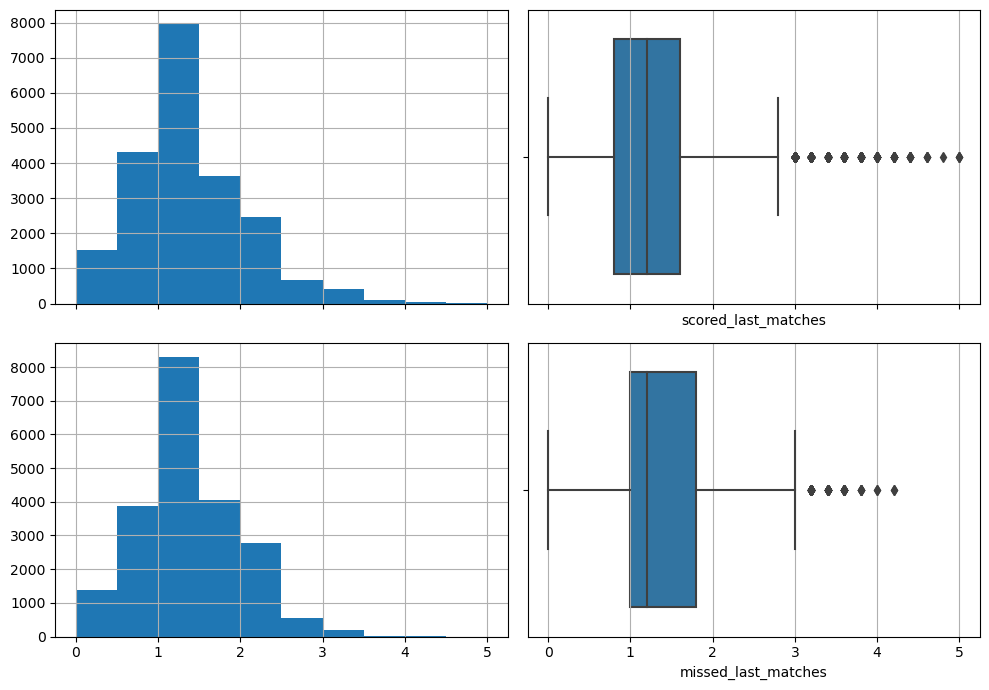

In [79]:
fig, axs = plt.subplots(2, 2, sharex=True, tight_layout=True, figsize=(10, 7))
axs[0,0].grid()
axs[1,0].grid()
axs[0,0].hist(data_to_train['scored_last_matches'], np.arange(0,5.5,0.5))
axs[1,0].hist(data_to_train['missed_last_matches'], np.arange(0,5.5,0.5))
axs[0,1].grid(axis='x')
sns.boxplot(x=data_to_train['scored_last_matches'], ax=axs[0,1])
axs[1,1].grid(axis='x')
sns.boxplot(x=data_to_train['missed_last_matches'], ax=axs[1,1])

In [80]:
data_to_train[['scored_last_matches', 'missed_last_matches']].quantile(0.95)

scored_last_matches    2.6
missed_last_matches    2.4
Name: 0.95, dtype: float64

На основании предложенных графиков и показателей, можно сказать, что среднее значение около 3 и выше забитых/пропущенных мячей в среднем за последние 5 матчей является редким, поэтому будем считать такие матчи выбросами и отфильтруем их. 
А также нормализуем, поделив на 3 все показатели с забитыми/пропущенными мячами.

In [81]:
data_to_train_filtered = data_to_train[(data_to_train['scored_last_matches'] <= 3) & (data_to_train['missed_last_matches'] <= 3) &
                                      (data_to_train['scored_last_matches_opp'] <= 3) & (data_to_train['missed_last_matches_opp'] <= 3)].copy()
goals_info = data_to_train_filtered[['scored_last_matches', 'missed_last_matches', 
                                   'scored_last_matches_opp', 'missed_last_matches_opp']]
scaler = MinMaxScaler()
scaler.fit(goals_info)
data_to_train_filtered[['scored_last_matches', 'missed_last_matches', 
                        'scored_last_matches_opp', 'missed_last_matches_opp']] = scaler.transform(goals_info)
data_to_train_filtered.describe()

,points_before,points_last_matches,scored_last_matches,missed_last_matches,points_before_opp,points_last_matches_opp,scored_last_matches_opp,missed_last_matches_opp
count,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000
mean,0.453242,0.452216,0.431820,0.442667,0.453242,0.452216,0.431820,0.442667
std,0.165517,0.219754,0.200958,0.193178,0.165517,0.219754,0.200958,0.193178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.266667,0.266667,0.333333,0.333333,0.266667,0.266667,0.333333
50%,0.433333,0.466667,0.400000,0.400000,0.433333,0.466667,0.400000,0.400000
75%,0.555556,0.600000,0.533333,0.600000,0.555556,0.600000,0.533333,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Обучение модели

Разделение на тестовую и тренировочную выборки.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(data_to_train_filtered.drop(['result'], axis=1), 
                                                    data_to_train_filtered['result'], 
                                                    random_state=3456, test_size=0.25)

## Константный предсказатель

In [83]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train);

In [84]:
y_pred_dummy = dummy_clf.predict(X_test)
accuracy_score(y_test, y_pred_dummy)

0.36168947055324213

In [85]:
f1_score(y_test, y_pred_dummy, average='macro')

0.17707878258336976

In [86]:
print(classification_report(y_test, y_pred_dummy, zero_division=0))

              precision    recall  f1-score   support

           d       0.00      0.00      0.00      1346
           l       0.00      0.00      0.00      1873
           w       0.36      1.00      0.53      1824

    accuracy                           0.36      5043
   macro avg       0.12      0.33      0.18      5043
weighted avg       0.13      0.36      0.19      5043



## Логистическая регрессия

In [87]:
model = LogisticRegression(multi_class='ovr', random_state=1111)
model.fit(X_train, y_train);
y_preds_logistic_regr = model.predict(X_test)
print(classification_report(y_test,y_preds_logistic_regr, zero_division=0))

              precision    recall  f1-score   support

           d       0.00      0.00      0.00      1346
           l       0.51      0.67      0.58      1873
           w       0.49      0.70      0.58      1824

    accuracy                           0.50      5043
   macro avg       0.33      0.45      0.38      5043
weighted avg       0.37      0.50      0.42      5043



## Метод kNN

In [88]:
knn = KNeighborsClassifier(n_neighbors=50, weights='uniform')
knn.fit(X_train, y_train)
y_preds_knn = knn.predict(X_test)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           d       0.34      0.06      0.10      1346
           l       0.50      0.65      0.57      1873
           w       0.50      0.65      0.56      1824

    accuracy                           0.49      5043
   macro avg       0.45      0.45      0.41      5043
weighted avg       0.46      0.49      0.44      5043



## Подведение итогов

Итоговые результаты:
|                      | accuracy | f1-score |
|----------------------|----------|----------|
| DummyClassifier      | 0.36     | 0.18     |
| LogisticRegression   | 0.50     | 0.38     |
| KNeighborsClassifier | 0.49     | 0.41     |